<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transfer Learning</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference</a></span></li></ul></div>

In [1]:
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Libraries")

import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_modelfrom sklearn.model_selection import train_test_split
import cv2
import time
import random
import colorsys
import numpy as np
from tensorflow.keras.regularizers import l2
from google.colab.patches import cv2_imshow

plt.style.use("dark_background")

Mounted at /content/drive


In [2]:
# Define Genralized IoU
def compute_giou(bbox1, bbox2):
    # boxes : (x1, y1, x2, y2)
    bbox1 = np.array(bbox1)
    bbox2 = np.array(bbox2)

    area_bbox1 = (bbox1[2] - bbox1[0])*(bbox1[3] - bbox1[1])
    area_bbox2 = (bbox2[2] - bbox2[0])*(bbox2[3] - bbox2[1])

    pt1_intersec = np.maximum(bbox1[:2], bbox2[:2])
    pt2_intersec = np.minimum(bbox1[2:], bbox2[2:])
    width_intersec, height_intersec = np.maximum(pt2_intersec - pt1_intersec, 0)
    area_intersec = width_intersec*height_intersec

    area_union = area_bbox1 + area_bbox2 - area_intersec

    iou = np.maximum(area_intersec/area_union, np.finfo(np.float32).eps)

    pt1_enclose = np.minimum(bbox1[:2], bbox2[:2])
    pt2_enclose = np.maximum(bbox1[2:], bbox2[2:])
    width_enclose, height_enclose = np.maximum(pt2_enclose - pt1_enclose, 0)
    area_enclose = width_enclose*height_enclose

    return iou - (area_enclose - area_union)/area_enclose

idx2cls = {}
with open("/content/drive/My Drive/Computer Vision/model_data/coco.names", "r") as data:
    for idx, cls in enumerate(data):
        idx2cls[idx] = cls.strip("\n")
n_clss = len(idx2cls)

# Modeling

In [3]:
class BatchNormalization(BatchNormalization):
    # When `layer.trainable=False` is set(inference mode), the layer is frozen and will use stored
    # moving `var` and `mean` and both `gamma` and `beta` will not be updated.
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(x, filters, kernel_size, downsample=False, activate=True, bn=True):
    if downsample==False:
        strides = 1
        padding = "same"
        z = x
    elif downsample==True:
        # top and left padding
        # shape: (batch_size, height, width, channels) -> (batch_size, height+1, width+1, channels)
        # the image size of the output is half the input.
        z = ZeroPadding2D(padding=((1, 0), (1, 0)))(x)
        strides = 2
        padding = "valid"

    z = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                bias_initializer=tf.constant_initializer(0.))(z)
    if bn == True:
        z = BatchNormalization()(z)
    if activate == True:
        z = LeakyReLU(alpha=0.1)(z)

    return z

def residual_block(x, filters):
    z = convolutional(x, filters=filters[0], kernel_size=1)
    z = convolutional(z, filters=filters[1], kernel_size=3)

    return Add()([x, z])

def upsample(x):
    return tf.image.resize(images=x, size=(x.shape[1]*2, x.shape[2]*2), method="nearest")

input_size = 416
channels = 3
inputs  = Input([input_size, input_size, channels])

# Darknet 53 from here(totally 75 layers).
z = convolutional(inputs, filters=32, kernel_size=3)
z = convolutional(z, filters=64, kernel_size=3, downsample=True)
for _ in range(1):
    z = residual_block(z, filters=[32, 64])
z = convolutional(z, filters=128, kernel_size=3, downsample=True)
for _ in range(2):
    z = residual_block(z, filters=[64, 128])
z = convolutional(z, filters=256, kernel_size=3, downsample=True)
for _ in range(8):
    z = residual_block(z, filters=[128, 256])
route1 = z

z = convolutional(z, filters=512, kernel_size=3, downsample=True)
for _ in range(8):
    z = residual_block(z, filters=[256, 512])
route2 = z

z = convolutional(z, filters=1024, kernel_size=3, downsample=True)
for _ in range(4):
    z = residual_block(z, filters=[512, 1024])

# YOLO v3 from here(totally 31 layers).
z = convolutional(z, filters=512, kernel_size=1)
z = convolutional(z, filters=1024, kernel_size=3)
z = convolutional(z, filters=512, kernel_size=1)
z = convolutional(z, filters=1024, kernel_size=3)
z = convolutional(z, filters=512, kernel_size=1)

conv_lobj_branch = convolutional(z, filters=1024, kernel_size=3)
# shape: (batch_size, 13, 13, 3*(n_clss + 5))
conv_lbbox = convolutional(conv_lobj_branch, filters=3*(n_clss + 5), kernel_size=1,
                            activate=False, bn=False)

z = convolutional(z, filters=256, kernel_size=1)
z = upsample(z)

z = Concatenate(axis=-1)([z, route2])

z = convolutional(z, filters=256, kernel_size=1)
z = convolutional(z, filters=512, kernel_size=3)
z = convolutional(z, filters=256, kernel_size=1)
z = convolutional(z, filters=512, kernel_size=3)
z = convolutional(z, filters=256, kernel_size=1)

conv_mobj_branch = convolutional(z, filters=512, kernel_size=3)
# shape: (batch_size, 26, 26, 3*(n_clss + 5))
conv_mbbox = convolutional(conv_mobj_branch, filters=3*(n_clss + 5), kernel_size=1,
                            activate=False, bn=False)

z = convolutional(z, filters=128, kernel_size=1)
z = upsample(z)

z = Concatenate(axis=-1)([z, route1])

z = convolutional(z, filters=128, kernel_size=1)
z = convolutional(z, filters=256, kernel_size=3)
z = convolutional(z, filters=128, kernel_size=1)
z = convolutional(z, filters=256, kernel_size=3)
z = convolutional(z, filters=128, kernel_size=1)

conv_sobj_branch = convolutional(z, filters=256, kernel_size=3)
# shape: (batch_size, 52, 52, 3*(n_clss + 5))
conv_sbbox = convolutional(conv_sobj_branch, filters=3*(n_clss + 5), kernel_size=1,
                            activate=False, bn=False)

n_grids = [52, 26, 13]
strides = [416/grid for grid in n_grids]
anchors = [[[10, 13], [16, 30], [33, 23]], [[30, 61], [62, 45], [59, 119]], [[116, 90], [156, 198],
                                                                             [373, 326]]]
anchors = (np.array(anchors).T/np.array(strides)).T

outputs = []
for i, conv_bbox in enumerate([conv_sbbox, conv_mbbox, conv_lbbox]):
    # shape: (batch_size, output_size, output_size, 3*(5 + n_clss)
    batch_size = tf.shape(conv_bbox)[0]
    # output_size = tf.shape(conv_bbox)[1]
    output_size = n_grids[i]
    conv_bbox = tf.reshape(conv_bbox, shape=(batch_size, output_size, output_size, 3, 5 + n_clss))
    xy = conv_bbox[:, :, :, :, 0:2] # offset of center position     
    wh = conv_bbox[:, :, :, :, 2:4] # Prediction box length and width offset
    conf = conv_bbox[:, :, :, :, 4:5] # confidence of the prediction box
    probs = conv_bbox[:, :, :, :, 5: ] # category probability of the prediction box 

    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])
    xy_grid = tf.concat([x[:, :, None], y[:, :, None]], axis=-1)
    # shape: (output_size, output_size, 2) -> (batch_size, output_size, output_size, 3, 2)
    xy_grid = tf.tile(xy_grid[None, :, :, None, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = (tf.math.sigmoid(xy) + xy_grid)*strides[i]
    pred_wh = (tf.math.exp(wh)*anchors[i])*strides[i]
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.math.sigmoid(conf)
    pred_probs = tf.math.sigmoid(probs)
            
    #outputs: [(batch_size, 52, 52, 3, 85), (batch_size, 26, 26, 3 85), (batch_size, 13, 13, 3, 85)]
    outputs.append(tf.concat([pred_xywh, pred_conf, pred_probs], axis=-1))

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Transfer Learning

In [4]:
# Transfer learning from Darknet 53 weights.
# Resets all state generated by Keras.
tf.keras.backend.clear_session()

with open("/content/drive/My Drive/Computer Vision/model_data/yolov3.weights", "rb") as f:
    _, _, _, _, _ = np.fromfile(f, dtype=np.int32, count=5)

    j = 0
    for i in range(75):
        conv_layer = model.get_layer("conv2d" if i == 0 else f"conv2d_{i}")
        filters = conv_layer.filters
        kernel_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]

        if i not in [58, 66, 74]:
            # order: [beta, gamma, mean, variance](darknet) -> [gamma, beta, mean, variance](tf)
            bn_weights = np.fromfile(f, dtype=np.float32, count=4*filters).reshape((4, filters))[[1, 0, 2, 3]]
            bn_layer = model.get_layer("batch_normalization" if j == 0 else f"batch_normalization_{j}")
            j += 1
        else:
            conv_bias = np.fromfile(f, dtype=np.float32, count=filters)

        conv_shape = (filters, in_dim, kernel_size, kernel_size)
        # shape: (out_dim, in_dim, height, width) -> (height, width, in_dim, out_dim)
        conv_weights = np.fromfile(f, dtype=np.float32, count=np.prod(conv_shape)).reshape(conv_shape)\
        .transpose((2, 3, 1, 0))

        if i not in [58, 66, 74]:
            conv_layer.set_weights([conv_weights])
            bn_layer.set_weights(bn_weights)
        else:
            conv_layer.set_weights([conv_weights, conv_bias])

# Inference

In [14]:
# ori_img = cv2.imread("/content/drive/My Drive/Computer Vision/Allhydrants-1920x1080-ca61f9ea607efb2f02f1ef97b781ee0f.jpg")
ori_img = cv2.imread("/content/drive/My Drive/Computer Vision/pizza.jpg")
# ori_img = cv2.imread("/content/drive/My Drive/Computer Vision/umbrella.jpg")
# ori_img = cv2.imread("/content/drive/My Drive/Computer Vision/baseball glove.jpg")

# preprocess_image
tar_height = input_size
tar_width = input_size
height, width, _ = ori_img.shape

scale = min(tar_height/height, tar_width/width)

new_width, new_height = int(scale*width), int(scale*height)
img_resized = cv2.resize(ori_img, dsize=(new_width, new_height))

img_padded = np.full(shape=(tar_height, tar_width, 3), fill_value=128.)
pad_width, pad_height = (tar_width - new_width)//2, (tar_height - new_height)//2
img_padded[pad_height:pad_height+new_height, pad_width:pad_width+new_width, :] = img_resized
img_padded = img_padded/255.
# Adds a dimension for batch size.
img_padded = img_padded[None, ...]

pred_bbox = model.predict(img_padded)
# shape: [(52*52*3, 85), (26*26*3, 85), (13*13*3, 85)]
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
# shape: ((52*52 + 26*26 + 13*13)*3, 85)
pred_bbox = tf.concat(pred_bbox, axis=0)


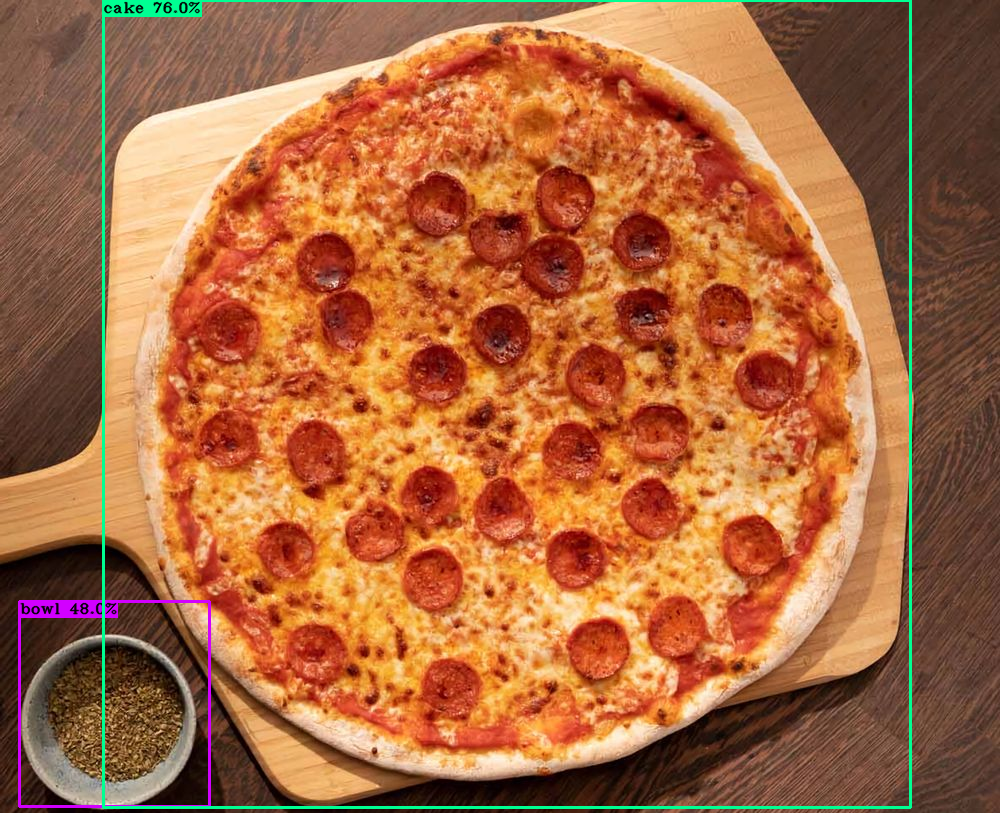

In [15]:
# postprocess_bboxes
# pred_bbox : (x, y, w, h, conf, prob)
# pred_bbox = np.array(pred_bbox)
valid_scale = [0, np.inf]

coors = pred_bbox[:, :4]
confs = pred_bbox[:, 4]
probs = pred_bbox[:, 5:]

# shape: (x, y, w, h) -> (x1, y1, x2, y2)
coors = np.concatenate([coors[:, :2] - coors[:, 2:]*0.5,
                        coors[:, :2] + coors[:, 2:]*0.5], axis=-1)

# (x1, y1, x2, y2) -> (x1_ori, y1_ori, x2_ori, y2_ori)
ori_height, ori_width = ori_img.shape[:2]
resize_ratio = min(input_size/ori_width, input_size/ori_height)

pad_width = (input_size - resize_ratio*ori_width)/2
pad_height = (input_size - resize_ratio*ori_height)/2

coors[:, (0, 2)] = (coors[:, (0, 2)] - pad_width)/resize_ratio
coors[:, (1, 3)] = (coors[:, (1, 3)] - pad_height)/resize_ratio

# Clip some boxes those are out of range(x1 <= x2인 박스 제거)
coors[:, :4] = np.concatenate([np.maximum(coors[:, (0, 1)], 0),
                            np.minimum(coors[:, (2, 3)], [ori_width-1, ori_height-1])], axis=-1)
coors[np.logical_or((coors[:, 0] > coors[:, 2]), (coors[:, 1] > coors[:, 3]))] = 0

# Discard some invalid boxes(음수 면적 제거)
bbox_area = np.sqrt(np.multiply.reduce(coors[:, (2, 3)] - coors[:, (0, 1)], axis=-1))
scale_mask = np.logical_and((bbox_area > valid_scale[0]), (bbox_area < valid_scale[1]))

# Discard bboxes with low scores
argmax = np.argmax(probs, axis=-1)
scores = confs*np.max(probs, axis=-1)
score_mask = scores > 0.3

pick_mask = np.logical_and(scale_mask, score_mask)

coors, scores, argmax = coors[pick_mask], scores[pick_mask], argmax[pick_mask]

bboxes = np.concatenate([coors, scores[:, None], argmax[:, None]], axis=-1)

# Perform non_maximum_suppression
bboxes = np.array(bboxes)
clss_in_img = list(set(bboxes[:, 5]))
best_bboxes = []
for cls in clss_in_img:
    bboxes_cls = bboxes[bboxes[:, 5] == cls]
    # Process 1: Determine whether the number of bounding boxes is greater than 0 
    while len(bboxes_cls) > 0:
        # Process 2: Select the bounding box with the highest score according to socre order A
        argmax = np.argmax(bboxes_cls[:, 4])
        best_bbox = bboxes_cls[argmax]
        best_bboxes.append(best_bbox)

        bboxes_cls = np.delete(bboxes_cls, argmax, axis=0)

        # Process 3: Calculate this bounding box A and remain all iou of the bounding box and remove
        # those bounding boxes whose iou value is higher than the thrsd.
        ious = np.array([compute_giou(best_bbox[:4], bbox_cls[:4]) for bbox_cls in bboxes_cls])

        bboxes_cls = bboxes_cls*(ious <= 0.45)[:, None]
        bboxes_cls = bboxes_cls[bboxes_cls[:, 4] > 0]

bboxes = best_bboxes
# Draw bboxes
img_height, img_width, _ = ori_img.shape

hsv_tuples = [(idx/n_clss, 1, 1) for idx in idx2cls.keys()]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0]*255.), int(x[1]*255.), int(x[2]*255.)), colors))

random.seed(0)
random.shuffle(colors)
random.seed(None)

for bbox in bboxes:
    coor = np.array(bbox[:4], dtype=np.int32)
    score = bbox[4]
    cls_idx = int(bbox[5])
    bbox_color = colors[cls_idx]
    bbox_thk = int(0.6*(img_height + img_width)/1000)
    bbox_thk = 1 if bbox_thk < 1 else bbox_thk
    font_scale = 0.75*bbox_thk
    (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

    cv2.rectangle(img=ori_img, pt1=(x1, y1), pt2=(x2, y2), color=bbox_color, thickness=bbox_thk*2)

    score_str = f"{score:.1%}" 
    label = f"{idx2cls[cls_idx]} " + score_str

    (text_width, text_height), baseline = cv2.getTextSize(text=label, fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                        fontScale=font_scale, thickness=bbox_thk)
    cv2.rectangle(img=ori_img, pt1=(x1, y1), pt2=(x1+text_width, y1+text_height+baseline),
                color=bbox_color, thickness=cv2.FILLED)
    cv2.putText(img=ori_img, text=label, org=(x1, y1+12), fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                fontScale=font_scale, color=(0, 0, 0), thickness=bbox_thk, lineType=cv2.LINE_AA)

cv2_imshow(ori_img)